In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np 
import os 
import matplotlib.pyplot as plt
import seaborn as sns     

In [2]:
# spark connection
from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType, DoubleType, TimestampType
from pyspark.sql import functions as F
# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("Preprocessing connection")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.memory", "4g")
    .config("spark.executor.memory", "8g")
    .getOrCreate()
)

22/08/22 04:52:58 WARN Utils: Your hostname, DESKTOP-L9KIK4G resolves to a loopback address: 127.0.1.1; using 172.23.126.166 instead (on interface eth0)
22/08/22 04:52:58 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/08/22 04:53:00 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Preparing weather data

In [3]:
# Looking at the weather data and keeping columns with data
df = pd.read_csv('../data/laguardia.csv')
df.rename(str.lower, axis='columns', inplace=True)
df = df[df.report_type.isin(['FM-12', 'FM-15', 'FM-16'])]   # other types or report are not interesting as per the data dictionary
df.drop('report_type', axis=1, inplace=True)

/tmp/ipykernel_203/2330021467.py:2: DtypeWarning: Columns (44,45,46) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/laguardia.csv')


In [4]:
# keeping interesting columns
df = df[['date', 'wnd', 'vis', 'tmp', 'dew', 'slp', 'ga1',]]

# loosely transcribed meaning of columns:

# wnd = wind angle clockwise,  quality code, wind obs type, WIND-OBSERVATION speed rate (x10), quality # 9999 missing

# vis = visibility distance, quality, variability, obs qual  # 999999=missing

# tmp = temp (x10), #+9999=missing
# dew = dewpoint(x10), #+9999=missing [dew point temperature The temperature to which a given parcel of air must be cooled at constant pressure and water vapor content in order for saturation to occur

# slp = atm pressure (x10), # 99999 = missing           [seal level pressure]
# ga1 = cloud cover (scale 0-8, 9&10=obstructed), quality, base height, quality, cloud type, quality


# Might be interesting columns:
# mw1 = weather name, quality
# oc1 = kui suured tuulepuhangud on (x10), quality

# df.drop(['source', 'station', 'latitude', 'longitude', 'name', 'elevation', 'call_sign', 'quality_control', 'cig', 'aa1', 'aa2', 'aa3', 'ab1', 'ad1', 'ae1', 'ah1', 'ah2', 'ah3', 'ah4', 'ah5', 'ah6', 'ai1', 'ai2', 'ai3', 'ai4', 'ai5', 'ai6', 'aj1', 'ak1', 'al1', 'am1', 'an1', 'at1', 'at2', 'at3', 'at4', 'at5', 'at6', 'at7', 'at8', 'au1', 'au2', 'au3', 'au4', 'aw1', 'aw2', 'aw3', 'aw4', 'aw5','ax1', 'ax2', 'ax3', 'ax4', 'ed1', 'ga2', 'ga3', 'gd1', 'gd2', 'gd3', 'gd4', 'ge1', 'gf1', 'ka1', 'ka2', 'kb1','kb2','kb3','kc1','kc2','kd1','kd2','ke1','kg1','kg2','ma1','md1', 'mf1','mg1','mh1','mk1','mv1','mw1','mw2','mw3','oc1','od1','oe1','oe2','oe3','rh1','rh2','rh3','rem','eqd'], axis=1)
df.head(5)

,date,wnd,vis,tmp,dew,slp,ga1
0,2019-01-01T00:00:00,"130,1,N,0041,1","008000,1,9,9","+0067,1","+0050,1","10201,1","99,9,+00250,1,99,9"
1,2019-01-01T00:49:00,"140,5,N,0067,5","003219,5,N,5","+0070,5","+0050,5","99999,9","07,5,+00244,5,99,9"
2,2019-01-01T00:51:00,"130,5,N,0067,5","003219,5,N,5","+0067,5","+0050,5","10181,5","07,5,+00244,5,99,9"
3,2019-01-01T01:15:00,"140,5,N,0046,5","011265,5,N,5","+0072,5","+0056,5","99999,9","07,5,+00244,5,99,9"
4,2019-01-01T01:25:00,"130,5,N,0051,5","002414,5,N,5","+0072,5","+0056,5","99999,9","07,5,+00244,5,99,9"


In [5]:
# spliting out the relevant information
df['date'] = pd.to_datetime(df['date'])
df['wnd'] = df['wnd'].str.split(',', expand=True)[3].astype(np.uint32)      # unit: m/s, scaling factor:10,     missing: 9999
df['vis'] = df['vis'].str.split(',', expand=True)[0].astype(np.uint32)      # unit: m,                          
df['tmp'] = df['tmp'].str.split(',', expand=True)[0].astype(np.int32)       # unit: C, scaling factor:10,       missing: 9999
df['dew'] = df['dew'].str.split(',', expand=True)[0].astype(np.int32)       # unit: C, scaling factor:10,       missing: 9999
df['atm'] = df['slp'].str.split(',', expand=True)[0].astype(np.uint32)      # unit: hP, scaling factor:10,      missing: 99999
df['ga1'].fillna('99,x', inplace=True)
df['cc'] = df['ga1'].str.split(',', expand=True)[0].astype(np.uint32).astype('category') # cloud coverage: unit: okta (0 clear -> 8 covered), 99 missing
df.drop(['slp', 'ga1'], axis=1, inplace=True)

In [6]:
df[df.isnull().any(axis=1)] # no NaN left

,date,wnd,vis,tmp,dew,atm,cc


In [8]:
# we will deal with the missing data later
df.describe()

,wnd,vis,tmp,dew,atm
count,13691.000000,13691.000000,13691.000000,13691.000000,13691.000000
mean,49.218538,14097.872982,134.312979,62.898693,23881.401505
std,88.596347,9506.640887,176.095325,247.540883,32309.299094
min,0.000000,0.000000,-156.000000,-272.000000,9858.000000
25%,31.000000,16000.000000,50.000000,-17.000000,10125.000000
50%,46.000000,16093.000000,133.000000,72.000000,10186.000000
75%,62.000000,16093.000000,217.000000,144.000000,10264.000000
max,9999.000000,999999.000000,9999.000000,9999.000000,99999.000000


In [10]:
day_count = 0

for group,df_group in df.groupby(df['date'].dt.date):
    day_count += 1
    h_count = 0
    for h, h_group in df_group.groupby(df_group['date'].dt.hour):
        h_count += 1
    if h_count != 24:
        print(f"Problem on date {group}, missing {24-h_count}")
if day_count != (df['date'].iloc[-1] - df['date'].iloc[0]).days:
    print("Some days are missing from dataset")


Problem on date 2019-03-13, missing 1
Problem on date 2019-03-16, missing 2
Problem on date 2019-05-10, missing 1
Problem on date 2019-05-31, missing 1
Problem on date 2019-09-27, missing 2
Problem on date 2019-10-02, missing 1
Problem on date 2019-10-25, missing 1
Some days are missing from dataset


In [11]:
df.to_csv('../data/curated/laguardia.csv')
# TODO values such as 9999 for missing are accounted for later

In [7]:
# same can be achieved by running script from terminal/importing here
# import sys
# sys.path.append('../scripts/')
# import weather_cleaning
# weather_cleaning.clean(range(2017, 2020))
# weather_cleaning.combine()

# Preparing taxi data


## Merging dataframes and removing conflicts
If there is a need to change the range on which analysis is performed, the first file that is read on both cases should be updated. Works best if files naming scheme makes them sorted chronologically

In [3]:
# FHV data, not working yet

# sdf_fhv = spark.read.parquet('../data/raw/fhv/')
# #problematic = ['congestion_surcharge', 'passenger_count', 'ratecodeID']

# #sdf_fhv = sdf_fhv.drop('ratecodeID', 'passenger_count', 'ehail_fee', 'payment_type', 'congestion_surcharge', 'trip_type')   
# new = sdf_fhv.withColumn("PUlocationID",F.col("PUlocationID").cast(DoubleType()))

# #new.limit(5)
# new.dtypes
# new.printSchema()
# new.limit(5)

# preliminary df re-formating to combine easier with others
for file in os.listdir('../data/raw/fhv/'):
    print(file)
    sdf = spark.read.parquet('../data/raw/fhv/'+file)
    sdf = sdf.drop('dispatching_base_num', 'SR_Flag', 'Affiliated_base_number')
    sdf.write.mode('overwrite').parquet('../data/temp/fhv/'+file)

2019_06.parquet


2017_06.parquet


2018_07.parquet


2017_07.parquet


2018_06.parquet


2019_08.parquet


2019_07.parquet


2017_08.parquet


2018_08.parquet


In [4]:
# preliminary df re-formating to combine easier with green
for file in os.listdir('../data/raw/yellow/'):
    print(file)
    sdf = spark.read.parquet('../data/raw/yellow/'+file)
    sdf = sdf.withColumn('passenger_count', sdf['passenger_count'].cast(IntegerType())) \
        .withColumn('congestion_surcharge', sdf['congestion_surcharge'].cast(IntegerType())) \
        .withColumn('ratecodeID', sdf['ratecodeID'].cast(IntegerType())) \
        .withColumnRenamed('tpep_pickup_datetime','pickup_datetime') \
        .withColumnRenamed('tpep_dropoff_datetime','dropoff_datetime') \
        .drop('airport_fee')    
    sdf.write.mode('overwrite').parquet('../data/temp/yellow/'+file)
    # congestion_surcharge: int->double, 
    # passenger_count long->double, 
    # ratecodeID long->double

2019_06.parquet


2017_06.parquet


2018_07.parquet


2017_07.parquet


2018_06.parquet


2019_08.parquet


2019_07.parquet


2017_08.parquet


2018_08.parquet


In [5]:
# preliminary df re-formating to combine easier with yellow
for file in os.listdir('../data/raw/green/'):
    print(file)
    sdf = spark.read.parquet('../data/raw/green/'+file)
    sdf = sdf.withColumn('passenger_count', sdf['passenger_count'].cast(IntegerType())) \
        .withColumn('ratecodeID', sdf['ratecodeID'].cast(IntegerType())) \
        .withColumnRenamed('lpep_pickup_datetime', 'pickup_datetime') \
        .withColumnRenamed('lpep_dropoff_datetime', 'dropoff_datetime') \
        .drop('ehail_fee', 'trip_type')

    sdf.write.mode('overwrite').parquet('../data/temp/green/'+file)


2019_06.parquet


2017_06.parquet


2018_07.parquet


2017_07.parquet


2018_06.parquet


2019_08.parquet


2019_07.parquet


2017_08.parquet


2018_08.parquet


In [6]:
sdf_yellow = spark.read.parquet('../data/temp/yellow/2017_06.parquet')

for file in sorted(os.listdir('../data/temp/yellow/'))[1:]:
    temp_df = spark.read.parquet('../data/temp/yellow/'+file)
    sdf_yellow = sdf_yellow.unionByName(temp_df)

# #problematic = ['congestion_surcharge', 'passenger_count', 'ratecodeID']
# df1 = spark.read.parquet('../data/curated/yellow/2019_08.parquet')
# df2 = spark.read.parquet('../data/curated/yellow/2017_06.parquet')

# sdf_yellow = df1.unionByName(df2)

#sdf_yellow.limit(5)
#print(sdf_yellow.count())
#merged_df.printSchema()

In [7]:
sdf_green = spark.read.parquet('../data/temp/green/2017_06.parquet')

for file in sorted(os.listdir('../data/temp/green/'))[1:]:
    temp_df = spark.read.parquet('../data/temp/green/'+file)
    sdf_green = sdf_green.unionByName(temp_df)

# #problematic = ['congestion_surcharge', 'passenger_count', 'ratecodeID']
# df1 = spark.read.parquet('../data/curated/yellow/2019_08.parquet')
# df2 = spark.read.parquet('../data/curated/yellow/2017_06.parquet')

# sdf_yellow = df1.unionByName(df2)

#sdf_green.limit(5)
#print(sdf_green.count())
#merged_df.printSchema()

In [8]:
sdf_fhv = spark.read.parquet('../data/temp/fhv/2017_06.parquet')

for file in sorted(os.listdir('../data/temp/fhv/'))[1:]:
    temp_df = spark.read.parquet('../data/temp/fhv/'+file)
    sdf_fhv = sdf_fhv.unionByName(temp_df)
sdf_fhv.write.mode('overwrite').parquet('../data/temp/fhv_clnd/raw_fhv.parquet')

In [9]:
# combine both green and yellow

sdf = sdf_yellow.unionByName(sdf_green)
# TODO do later
sdf = sdf.withColumn('PUWeekday', (F.dayofweek(F.col('pickup_datetime')))) \
        .withColumn('PUHour', F.hour(F.col('pickup_datetime')))

In [10]:
#sdf = sdf.drop('congestion_surcharge')
sdf.write.mode('overwrite').parquet('../data/temp/both/raw_data.parquet')

## Exploring raw data
This step here is purposefully done without the FHV dataset, as it has almost no attributes to explore.

In [27]:
sdf = spark.read.parquet('../data/temp/both/raw_data.parquet')

In [28]:
#sdf.select().summary()

sdf.select(F.col('passenger_count'),
           F.col('trip_distance'),
           F.col('total_amount'),
           ((F.col('dropoff_datetime').cast('long')-F.col('pickup_datetime').cast('long'))/60).alias('trip_duration')).summary()


summary,passenger_count,trip_distance,total_amount,trip_duration
count,76490436,76727886,76727886,76727886
mean,1.5844927854771282,3.046011726557799,17.29796580387482,17.430782800834642
stddev,1.2321364442743852,6.995279973385103,187.244831344472,1699.8001975945697
min,0,0.0,-1871.8,-1.05191844333333...
25%,1,1.0,9.3,6.633333333333334
50%,1,1.7,12.8,11.183333333333334
75%,2,3.2,18.96,18.45
max,9,45977.22,907071.04,36501.183333333334


In [29]:
print(sdf.select(F.min(F.col("PULocationID"))).limit(1).collect()[0])
print(sdf.select(F.min(F.col("DOLocationID"))).limit(1).collect()[0])
print(sdf.select(F.max(F.col("PULocationID"))).limit(1).collect()[0])
print(sdf.select(F.max(F.col("DOLocationID"))).limit(1).collect()[0])
# ZoneID has to be in [1-263]

Row(min(PULocationID)=1)
Row(min(DOLocationID)=1)
Row(max(PULocationID)=265)
Row(max(DOLocationID)=265)


In [65]:
plt.rcParams['savefig.dpi'] = 300

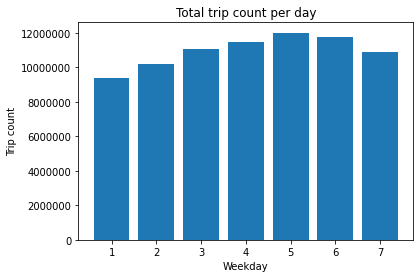

In [43]:
# plot of trip_count per day of week
count_by_day = sdf.select(F.col('PUWeekday')).groupby('PUWeekday').count().sort(F.asc("PUWeekday")).toPandas()
plt.bar(count_by_day['PUWeekday'], count_by_day['count'])
plt.title("Total trip count per day")
plt.ylabel("Trip count")
plt.xlabel("Weekday")
plt.ticklabel_format(style='plain')    # to prevent scientific notation.
plt.savefig('../plots/tripcount_day.jpeg')
plt.show()

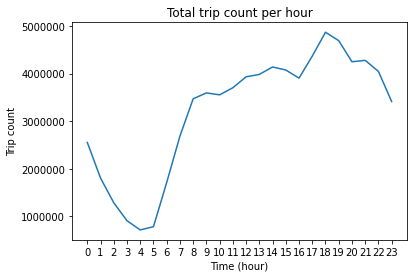

In [42]:
# plot of trip_count per hour of day
count_by_hour = sdf.select(F.col('PUHour')).groupby('PUHour').count().sort(F.asc("PUHour")).toPandas()
plt.plot(count_by_hour['PUHour'], count_by_hour['count'])
plt.title("Total trip count per hour")
plt.xticks(np.arange(0, 24))
plt.ylabel("Trip count")
plt.xlabel("Time (hour)")
plt.ticklabel_format(style='plain')    # to prevent scientific notation.
plt.savefig('../plots/tripcount_hour.jpeg')
plt.show()

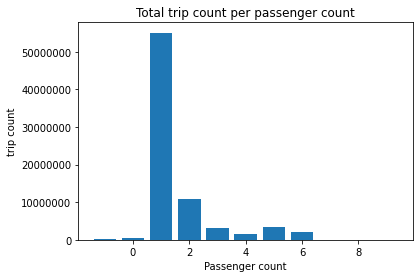

In [41]:
# plot of n of trips against passegner count
passenger_count = sdf.select(F.col('passenger_count')).groupby('passenger_count').count().sort(F.asc("passenger_count")).toPandas()
passenger_count.iat[0, 0] = -1  # quick way to deal with NaN
plt.bar(passenger_count['passenger_count'],passenger_count['count'])
plt.title("Total trip count per passenger count")
plt.ylabel("trip count")
plt.xlabel("Passenger count")
plt.ticklabel_format(style='plain')    # to prevent scientific notation.
plt.savefig('../plots/tripcount_passengercount.jpeg')
plt.show()

In [44]:
df = sdf.sample(False, 0.01, 42).toPandas()

In [45]:
df.shape

(768203, 20)

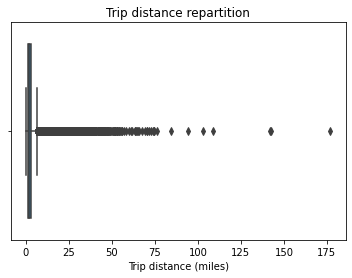

In [57]:
# Really unbalaned
sns.boxplot(x=df['trip_distance'])
plt.title('Trip distance repartition')
plt.xlabel('Trip distance (miles)')
plt.savefig('../plots/tripdistances.jpeg')

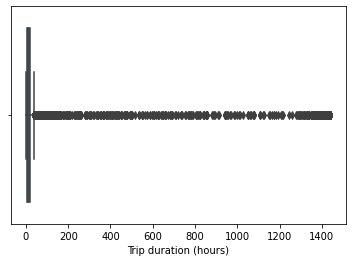

In [58]:
sns.boxplot(x=(df['dropoff_datetime']-df['pickup_datetime'])/np.timedelta64(60, 's'))
plt.xlabel('Trip duration (hours)')
plt.savefig('../plots/triplenghts.jpeg')
plt.show()

<AxesSubplot:xlabel='PUWeekday', ylabel='trip_distance'>

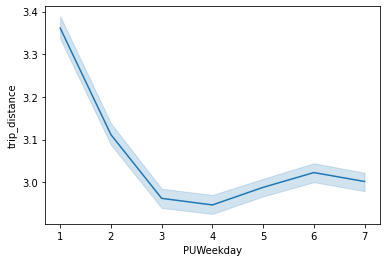

In [59]:
sns.lineplot(x='PUWeekday', y='trip_distance',data=df)

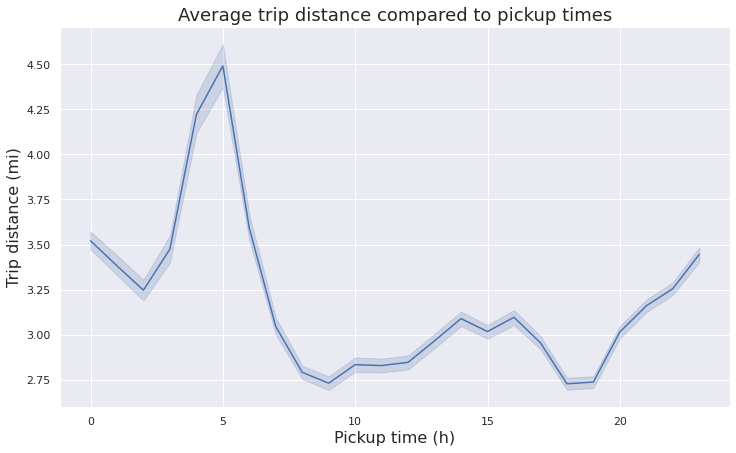

In [67]:
sns.set(rc = {'figure.figsize':(12,7)})
sns.lineplot(x='PUHour', y='trip_distance',data=df)
plt.xlabel('Pickup time (h)', fontsize=16)
plt.ylabel('Trip distance (mi)', fontsize=16)
plt.title('Average trip distance compared to pickup times', fontsize=18)
plt.savefig('../plots/pickuptime_distance.jpeg')
plt.show()

In [69]:
asi = sdf.select(F.col('PUHour'), F.col('PUWeekday'), F.col('trip_distance')).groupby('PUHour', 'PUWeekday').avg().toPandas()

In [70]:
asi = asi[['PUHour', 'PUWeekday', 'avg(trip_distance)']]
temp = []
for hour in range(0, 24):
    temp2 = []
    for day in range(1, 8):
        temp2.append(asi[(asi['PUHour'] == hour) & (
            asi['PUWeekday'] == day)]['avg(trip_distance)'].iloc[0])
    temp.append(temp2)

temp3 = pd.DataFrame(temp, columns=[x for x in range(1, 8)])

[]

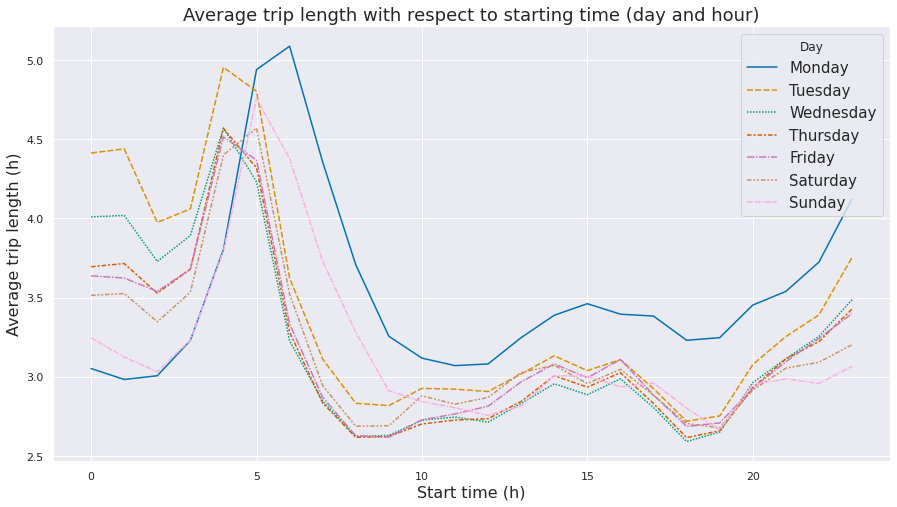

In [80]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.lineplot(data=temp3, palette='colorblind', linestyle='--')
plt.legend(title='Day', loc='upper right', labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], fontsize=15)
plt.title("Average trip length with respect to starting time (day and hour)", fontsize=18)
plt.ylabel("Average trip length (h)", fontsize=16)
plt.xlabel("Start time (h)", fontsize=16)
plt.savefig('../plots/length_day_hour.jpeg')

plt.plot()

<AxesSubplot:xlabel='PUWeekday', ylabel='trip_distance'>

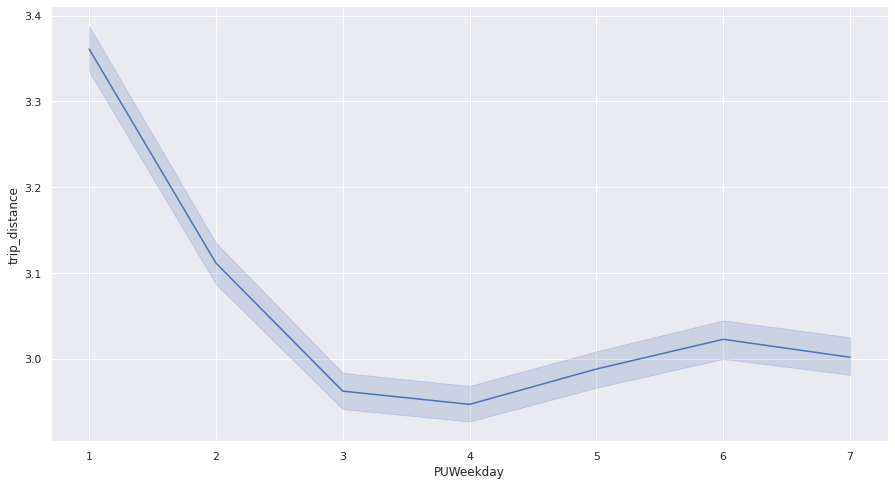

In [81]:
sns.lineplot(x='PUWeekday', y='trip_distance',data=df)

<AxesSubplot:xlabel='trip_distance', ylabel='Frequency'>

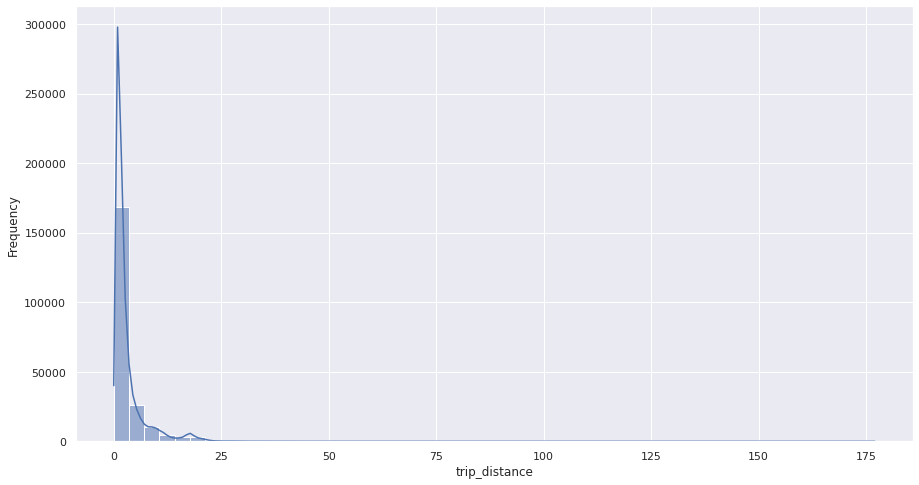

In [82]:
sns.histplot(data=df,
             x="trip_distance",
             stat="frequency",    # normalize the histogram so that the total area of bars is 1
             kde=True,          # plot kernel density estimate
             bins=50            # number of bins of the histogram
            )

## Filtering out outliers and keeping important variables

In [11]:
sdf = spark.read.parquet('../data/temp/both/raw_data.parquet')

In [84]:
sdf.limit(1)

VendorID,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,ratecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,PUWeekday,PUHour
1,2018-06-01 00:15:40,2018-06-01 00:16:46,1,0.0,1,N,145,145,2.0,3.0,0.5,0.5,0.0,0.0,0.3,4.3,null,6,0


In [12]:
trip_dist_upper = 150
trip_duration_uper = 6*60

total_amount_upper = 5000



def modify_sdf(sdf):
    return sdf \
        .drop('VendorID', 'ratecodeID', 'store_and_fwd_flag', 'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'congestion_surcharge') \
        .dropna(how='any') \
        .filter((F.month('pickup_datetime') >= 6) & (F.month('dropoff_datetime') <= 8) == True) \
        .filter((F.year('pickup_datetime').isin([2017, 2018, 2019])) & (F.year('dropoff_datetime').isin([2017, 2018, 2019]))) \
        .filter(F.col('passenger_count') > 0) \
        .filter((F.col('trip_distance') > 0) & (F.col('trip_distance') < trip_dist_upper)) \
        .filter((F.col('PULocationID') < 264) & (F.col('DOLocationID') < 264)) \
        .filter((F.col('total_amount') > 0) & (F.col('total_amount') < total_amount_upper)) \
        .withColumn('trip_duration', (F.col('dropoff_datetime').cast('long')-F.col('pickup_datetime').cast('long'))/60) \
        .filter((F.col('trip_duration') > 0) & (F.col('trip_duration') < trip_duration_uper)) \
        .withColumn('PUMonth', F.month(F.col('pickup_datetime'))) \
        .withColumn('PUDay', F.dayofmonth(F.col('pickup_datetime'))) #\
        #.drop('pickup_datetime', 'dropoff_datetime')

print(sdf.count())
#sdf.select([F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c)           for c in sdf.columns if not c in ['pickup_datetime', 'dropoff_datetime']]).show()
new_sdf = modify_sdf(sdf)
new_sdf.write.mode('overwrite').parquet('../data/temp/both_bit_cleaned/bit_cleaned_data.parquet')
print(new_sdf.count())
new_sdf.limit(1)


76727886


74017846


pickup_datetime,dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,total_amount,PUWeekday,PUHour,trip_duration,PUMonth,PUDay
2018-07-01 00:28:09,2018-07-01 00:28:51,1,5.3,145,145,3.8,1,0,0.7,7,1


In [87]:
new_sdf.select(F.col('passenger_count'),
           F.col('trip_distance'),
           F.col('total_amount'),
           F.col('trip_duration')).summary()

ERROR:root:Exception while sending command.                        (4 + 4) / 13]
Traceback (most recent call last):
  File "/home/toomas/ADS/adsenv/lib/python3.8/site-packages/py4j/clientserver.py", line 516, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/toomas/ADS/adsenv/lib/python3.8/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/home/toomas/ADS/adsenv/lib/python3.8/site-packages/py4j/clientserver.py", line 539, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while sending or receiving


#
# A fatal error has been detected by the Java Runtime Environment:
#
#  SIGSEGV (0xb) at pc=0x00007f372e3d60e8, pid=294, tid=0x00007f372c108700
#
# JRE version: OpenJDK Runtime Environment (8.0_312-b07) (build 1.8.0_312-8u312-b07-0ubuntu1~20.04-b07)
# Java VM: OpenJDK 64-Bit Server VM (25.312-b07 mixed mode linux-amd64 compressed oops)
# Problematic frame:
# V  [libjvm.so+0x9ef0e8]
#
# Failed to write core dump. Core dumps have been disabled. To enable core dumping, try "ulimit -c unlimited" before starting Java again
#
# An error report file with more information is saved as:
# /home/toomas/ADS/mast30034-project-1-ToomasRo/notebooks/hs_err_pid294.log
#
# If you would like to submit a bug report, please visit:
#   http://bugreport.java.com/bugreport/crash.jsp
#


Py4JError: An error occurred while calling o1437.summary

# Merging Datasets

In [15]:
sdf = spark.read.parquet('../data/temp/both_bit_cleaned/bit_cleaned_data.parquet')
weather_df = pd.read_csv('../data/curated/weather/laguardia.csv')
sdf_fhv = spark.read.parquet('../data/temp/fhv_clnd/raw_fhv.parquet/')

In [21]:
def cc_average(data):
    data = [x for x in data if x!=99]
    return sum(data)/len(data) if len(data)>0 else 99
# replace missing value with average of said hour
def missing_impute(data, missing_val):
    data = [x for x in data if x!=missing_val]
    return sum(data)/len(data) if len(data)>0 else 9999999

In [22]:
# rounding time to hour precision
weather_df['date'] = pd.to_datetime(weather_df['date']).dt.floor('h')
# if there are multiple entries to same hour, keep one and take the average values, 
# except for cloud coverage, as if on is 99 then the value was missing, so we keep the same value as the non missing one
df = pd.DataFrame(weather_df['date'].unique())
df.columns = ['time']
df['wnd'] = weather_df.groupby('date')['wnd'].agg(missing_impute, 9999).values
df['vis'] = weather_df.groupby('date')['vis'].agg(missing_impute, 999999).values
df['tmp'] = weather_df.groupby('date')['tmp'].agg(missing_impute, 9999).values
df['dew'] = weather_df.groupby('date')['dew'].agg(missing_impute, 9999).values
df['atm'] = weather_df.groupby('date')['atm'].agg(missing_impute, 99999).values
df['cc'] = weather_df.groupby('date')['cc'].agg(missing_impute, 99).values

In [39]:
print(df.shape)
df = df[(df['wnd'] != 9999)]
df = df[(df['vis'] != 999999)]
df = df[(df['tmp'] != 9999)] 
df = df[(df['dew'] != 9999)] 
df = df[(df['atm'] != 99999)]
print(df.shape)

(26200, 7)
(26200, 7)


In [40]:
sparkDF = spark.createDataFrame(df) 
# spark utc setting does not work, so adding manualy time
# TODO find cleaner way
# source: https://www.datasciencemadesimple.com/add-hours-minutes-and-seconds-to-timestamp-in-pyspark/
sparkDF = sparkDF.withColumn('time', F.col('time')+F.expr('INTERVAL 10 HOURS'))
#sparkDF.limit(5)

In [41]:
sdf = sdf.unionByName(sdf_fhv.dropna('any'), allowMissingColumns=True)

In [42]:
# truncate pickuptime to nearest hour
# adapted from https://stackoverflow.com/questions/34232042/pyspark-1-5-how-to-truncate-timestamp-to-nearest-minute-from-seconds
sdf = sdf.withColumn("dt_truncated", F.date_trunc("hour", F.col("pickup_datetime")))

In [43]:
# find the number of pickups per zone per hour
sdf.limit(1)

pickup_datetime,dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,total_amount,PUWeekday,PUHour,trip_duration,PUMonth,PUDay,dt_truncated
2017-07-01 00:06:25,2017-07-01 00:10:50,1,1.2,249.0,90.0,8.15,7,0,4.416666666666667,7,1,2017-07-01 00:00:00


In [44]:
#merged_sdf.limit(5)
c_sdf = sdf.groupBy(F.col('dt_truncated').alias('cdt'), F.col('PULocationID').alias('puid')).count()

In [37]:
c_sdf.limit(1)

cdt,puid,count
2017-07-02 01:00:00,163.0,315


In [50]:
sdf.join(c_sdf, (sdf.dt_truncated == c_sdf.cdt) & (sdf.PULocationID == c_sdf.puid), 'inner') \
    .join(sparkDF, sdf.dt_truncated == sparkDF.time, "inner") \
    .withColumn('PUWeekday', (F.dayofweek(F.col('pickup_datetime')))) \
    .withColumn('PUHour', F.hour(F.col('pickup_datetime'))) \
    .withColumn('PUMonth', F.month(F.col('pickup_datetime'))) \
    .withColumn('PUDay', F.dayofmonth(F.col('pickup_datetime'))) \
    .drop('dropoff_datetime', 'time', 'passenger_count', 'trip_distance', 'total_amount', 'trip_duration', 'cdt', 'dt_truncated', 'puid') \
    .write.mode('overwrite').parquet('../data/curated/final3/clean_dataset.parquet')

In [46]:
#final_sdf.write.mode('overwrite').parquet('../data/curated/final3/clean_dataset.parquet')

In [52]:
final_sdf = spark.read.parquet('../data/curated/final3/clean_dataset.parquet')

pickup_datetime,PULocationID,DOLocationID,PUWeekday,PUHour,PUMonth,PUDay,count,wnd,vis,tmp,dew,atm,cc
2017-06-01 00:04:45,62.0,188.0,5,0,6,1,90,33.5,16046.5,197.5,156.0,10130.0,2.0
2017-06-01 00:16:00,62.0,85.0,5,0,6,1,90,33.5,16046.5,197.5,156.0,10130.0,2.0
2017-06-01 00:13:44,62.0,85.0,5,0,6,1,90,33.5,16046.5,197.5,156.0,10130.0,2.0
2017-06-01 00:31:38,62.0,49.0,5,0,6,1,90,33.5,16046.5,197.5,156.0,10130.0,2.0
2017-06-01 00:33:57,62.0,17.0,5,0,6,1,90,33.5,16046.5,197.5,156.0,10130.0,2.0
2017-06-01 00:28:17,62.0,35.0,5,0,6,1,90,33.5,16046.5,197.5,156.0,10130.0,2.0
2017-06-01 00:34:04,62.0,37.0,5,0,6,1,90,33.5,16046.5,197.5,156.0,10130.0,2.0
2017-06-01 00:21:48,62.0,255.0,5,0,6,1,90,33.5,16046.5,197.5,156.0,10130.0,2.0
2017-06-01 00:09:12,62.0,67.0,5,0,6,1,90,33.5,16046.5,197.5,156.0,10130.0,2.0
2017-06-01 00:50:54,62.0,37.0,5,0,6,1,90,33.5,16046.5,197.5,156.0,10130.0,2.0


In [49]:
final_sdf.select(F.col('count')).summary()

summary,count
count,271934805
mean,763.7702879004399
stddev,1023.5195369722124
min,1
25%,220
50%,492
75%,925
max,10164


In [53]:
final_sdf.count()

271934805

### Making sure temperatures are correct
I had a problem with spark setting timezones to the dates from there. Therefore, I plotted the data in excel as well, and since Melbourne is UTC-10, it made sense that 10 hours should be added. This was confirmed by visual proof.

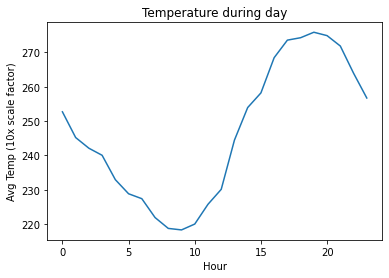

In [54]:
# top x cells in one go

sparkDF = spark.createDataFrame(df) 
# spark utc setting does not work, so adding manualy time, because MEL is utc-10
# TODO find cleaner way
# source: https://www.datasciencemadesimple.com/add-hours-minutes-and-seconds-to-timestamp-in-pyspark/
sparkDF = sparkDF.withColumn('time', F.col('time')+F.expr('INTERVAL 10 HOURS'))
#sparkDF.limit(5)
merged_sdf = sdf.join(sparkDF,sdf.dt_truncated ==  sparkDF.time,"inner")
#merged_sdf.write.mode('overwrite').parquet('../data/temp/merged/merged.parquet')
#n_sdf = spark.read.parquet('../data/temp/merged/merged.parquet')
temperature_df = merged_sdf.select(F.col('tmp'), F.col('PUHour')).groupby('PUHour').avg().sort(F.asc("PUHour")).toPandas()
plt.plot(temperature_df['PUHour'], temperature_df['avg(tmp)'])
plt.title("Temperature during day")
plt.ylabel("Avg Temp (10x scale factor)")
plt.xlabel("Hour")
plt.show()

In [ ]:
# final_sdf.select(F.col('wnd'), F.col('vis'), F.col('tmp'),
#                 F.col('dew'), F.col('atm'), F.col('cc')).summary()